<a href="https://colab.research.google.com/github/PTA70183292/practic/blob/main/notebooks/otchet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Блокнот ВКР студента **Пернеева Талгатбека Асилбековича**

группы о.ИЗДт 23.2/Б3-21

на тему **«Разработка интеллектуальной системы определения эмоциональной окраски сообщений в Центре поддержки»**

На основе датасета https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset

## **Установка библиотек**
В данном блоке выполняется установка библиотек, необходимых для реализации интеллектуального сервиса анализа тональности текстов. Используются библиотеки для обработки естественного языка, машинного обучения, глубокого обучения и работы с предобученными трансформерными моделями. Установка выполняется в среде Google Colab, что обеспечивает воспроизводимость экспериментов и корректную работу всех зависимостей.

In [ ]:
!pip install -q -U transformers datasets accelerate peft bitsandbytes pymorphy3 gensim torchinfo

# -q (quiet)    Подавляет вывод прогресса установки.
# -U (upgrade)  Обновляет пакеты до последней версии, если они уже установлены.
# transformers  Библиотека Hugging Face для загрузки и дообучения предобученных трансформеров (BERT).
# datasets      Библиотека Hugging Face для эффективной загрузки и быстрой обработки больших наборов данных.
# accelerate    Инструмент для масштабирования PyTorch-моделей (автоматизирует работу с GPU/TPU внутри Trainer).
# peft          Библиотека для Parameter-Efficient Fine-Tuning (LoRA), снижающая нагрузку на видеопамять.
# bitsandbytes  Реализация 8-битного квантования для работы с тяжелыми моделями на обычных GPU.
# pymorphy3     Морфологический анализатор для русского языка (приведение слов к нормальной форме/лемме).
# gensim        Библиотека для тематического моделирования и работы с векторными эмбеддингами слов (Word2Vec).
# torchinfo      Для генерации детальной сводки архитектуры нейронной сети


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 92.2 MB/s eta 0:00:00


### **Импорт библиотек и настройка окружения**
В данном блоке выполняется импорт стандартных и специализированных библиотек, необходимых для реализации полного конвейера интеллектуального анализа тональности текстов: от предварительной обработки и классических методов машинного обучения до обучения и дообучения нейросетевых моделей трансформерной архитектуры. Дополнительно производится настройка среды выполнения, включая выбор вычислительного устройства (CPU/GPU), подавление вспомогательных предупреждений, отключение внешних сервисов логирования и загрузку лингвистических ресурсов для корректной обработки русскоязычных текстов.

In [2]:
import os                        # Взаимодействие с ОС. Используется для отключения логов Weights & Biases и проверки путей к данным.
import re                        # Регулярные выражения. Применяются для очистки текста (удаление тегов, ссылок) перед анализом.
import warnings                  # Управление предупреждениями.
import math                      # Математические функции. Используется для расчета шагов обучения (steps).
import gc                        # Сборщик мусора. Вызываем gc.collect() для очистки памяти GPU перед загрузкой новой модели.
import numpy as np               # Матричные вычисления. Преобразует логиты (выходы модели) в вероятности классов.
import pandas as pd              # Работа с таблицами. Загружает датасет в удобный DataFrame.
import matplotlib.pyplot as plt  # Визуализация. Строит графики потерь (loss) и распределения классов.

# NLP & ML (Классические методы)
import nltk        # Базовая NLP библиотека. Нужна для работы со стоп-словами.
import pymorphy3   # Морфологический анализатор. Лемматизирует слова (приводит к начальной форме) для чистоты словаря.

from sklearn.feature_extraction.text import CountVectorizer # Мешок слов. Векторизатор для простых моделей.
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF. Оценивает важность слов, используется для сравнения с нейросетями.
from sklearn.linear_model import LogisticRegression         # Логистическая регрессия. Базовое решение для проверки гипотез.
from sklearn.naive_bayes import BernoulliNB                 # Наивный Байес. Быстрый вероятностный классификатор для текстовых данных.
from sklearn.metrics import (
    accuracy_score,                 # Метрика точность (общая доля правильных ответов).
    classification_report,          # Полный отчет (Precision, Recall, F1) по каждому классу.
    f1_score                        # F1-мера. Метрика качества для несбалансированных классов.
)
from gensim.models import Word2Vec  # Векторные представления. Обучает эмбеддинги слов для анализа семантической близости.

#  Deep Learning (PyTorch)
import torch                        # Основной фреймворк. На нем строятся тензоры и выполняются вычисления на GPU.
import torch.nn as nn               # Нейросетевые слои. Содержит функции потерь (CrossEntropy) и слои архитектуры.
import torch.optim as optim         # Оптимизаторы. Обновляет веса модели (например, AdamW (уменьшение ошибки)).
from torch.cuda.amp import (        # Импорт инструментов Automatic Mixed Precision (AMP) для ускорения обучения и снижения потребления GPU-памяти за счёт вычислений в смешанной точности (float16 + float32)
    GradScaler,
    autocast
)
from torch.utils.data import (
    DataLoader,                     # Загрузчик данных. Формирует батчи (пакеты) для подачи в модель.
    Dataset                         # Класс данных. Обертка для подачи текстов в PyTorch.
)
from torchinfo import summary       # Используемой для анализа и визуализации архитектуры нейросетевой модели, включая структуру слоёв, размерности выходов и количество обучаемых параметров.

# Transformers и Hugging Face
from huggingface_hub import HfApi, login                # API Hugging Face. Для доступа к репозиторию и загрузки моделей.
from datasets import load_dataset, concatenate_datasets # Загрузка данных. Оптимизированный формат для работы с большими текстами.
from tqdm.auto import tqdm                              # Индикатор прогресса.

from transformers import (
    AutoModelForSequenceClassification,     # Загружает архитектуру (в т.ч. BERT) с готовой "головой" для классификации.
    AutoTokenizer,                          # Токенизатор. Превращает текст в ID токенов, понятных модели.
    BitsAndBytesConfig,                     # Конфиг квантования. Сжимает веса до 8 бит для экономии памяти GPU.
    Trainer,                                # Класс "Тренер". Управляет циклом обучения, валидацией и сохранением.
    TrainingArguments,                      # Гиперпараметры. Задает learning_rate, batch_size, число эпох.
    TrainerCallback                         # Колбэки. Позволяет логировать метрики или прерывать обучение.
)

from peft import (
    LoraConfig,                             # Конфиг LoRA. Настраивает ранг (r) адаптеров для эффективного обучения.
    get_peft_model,                         # Применяет LoRA. Оборачивает базовую модель, делая обучаемыми только адаптеры.
    prepare_model_for_kbit_training         # Подготовка. Замораживает веса для стабильного квантованного обучения.
)

# Настройки окружения
os.environ ["WANDB_DISABLED"] = "true"                  # Отключаем W&B для локального логирования.
warnings.filterwarnings('ignore')                       # Скрываем технические предупреждения для чистоты вывода.
device = "cuda" if torch.cuda.is_available() else "cpu" # Используем GPU для ускорения обучения.

# Загрузка ресурсов NLTK
nltk.download(['stopwords', 'punkt_tab'], quiet=True)   # Скачиваем словари тихо, без лишнего вывода.
from nltk.corpus import stopwords                       # Импорт стоп-слов.
from nltk.tokenize import word_tokenize                 # Импорт токенизатора слов.

RUSSIAN_STOP_WORDS = set(stopwords.words('russian'))    # Множество русских стоп-слов для быстрой фильтрации текста.

# Обоснование выбора библиотек

### Стандартные библиотеки Python

**os**  необходима для управления переменными окружения (отключение Weights & Biases через WANDB_DISABLED="true"), работы с путями к моделям и датасетам. В production-среде используется для конфигурации через переменные окружения без изменения кода.

**re (Regular Expressions)**  критически важна для предобработки текстов. Используется для удаления упоминаний пользователей @username, цифр, нецириллических символов и нормализации пробелов через скомпилированные паттерны, что в 3-5 раз быстрее обычных строковых методов.

**warnings**  подавляет некритичные предупреждения от библиотек (FutureWarning, DeprecationWarning), которые загромождают вывод блокнота и затрудняют отладку. Особенно важно при работе с библиотекой transformers, генерирующей множество предупреждений о будущих изменениях API.

**math**  используется в реализации кастомного Transformer для вычисления синусоидальных позиционных кодировок PositionalEncoding. Необходима для функции math.log(10000.0) при расчете частот для sin/cos.

**gc (Garbage Collector)**  обязательна для ручной очистки памяти GPU после удаления моделей. В Google Colab с ограниченными 15GB GPU-памяти Tesla T4 вызовы gc.collect() и torch.cuda.empty_cache() предотвращают ошибки OutOfMemory при переключении между моделями.

### Научные вычисления и визуализация

**numpy**  фундаментальная библиотека для векторных операций с эмбеддингами Word2Vec (матрицы размера N×60×100), вычисления перцентилей длин текстов (np.percentile(lengths, 95)) и преобразования предсказаний PyTorch в массивы для scikit-learn метрик.

**pandas**  используется для табличного представления результатов сравнения моделей (Accuracy, F1-Macro, F1-Weighted по каждой модели) и удобного вывода через DataFrame.T для транспонирования. Упрощает анализ производительности базовых моделей против трансформеров.

**matplotlib**  визуализирует распределение длин текстов в датасете для определения оптимального значения max_length (95-й перцентиль). Гистограммы помогают обосновать выбор параметров токенизации и выявить выбросы.

### NLP и морфологический анализ

**nltk**  предоставляет готовый список из 151 русского стоп-слова (stopwords.words(russian)) и токенизатор word_tokenize на основе правил. Выбран как стандарт индустрии для базовой обработки текста с поддержкой 30+ языков.

**pymorphy3**  единственная активно поддерживаемая библиотека для морфологического анализа русского языка с точностью лемматизации >95%. Приводит словоформы к нормальной форме ("обращения" → "обращение"), что критично для русского с его богатой морфологией.

### Deep Learning фреймворк

**PyTorch**  выбран как основной фреймворк глубокого обучения вместо TensorFlow по трем причинам: 1 нативная поддержка в библиотеке transformers от Hugging Face, 2 динамические вычислительные графы упрощают отладку кастомного Transformer, 3 библиотека bitsandbytes для 8-битного квантования работает только с PyTorch.

**torch.nn**  содержит все необходимые слои для построения нейросетевых архитектур: Linear для проекций Q/K/V в MultiHeadAttention, Embedding для токенов, LayerNorm для нормализации, Dropout для регуляризации. Используется как в кастомном Transformer (8 слоев энкодера), так и для дообучения RuBERT.

**torch.optim**  предоставляет оптимизатор AdamW с весовым затуханием, рекомендованный для файнтюнинга трансформеров. Выбран вместо обычного Adam из-за лучшей генерализации и используется в Trainer с learning rate 2e-5.

**DataLoader и Dataset**  обеспечивают эффективную батч-загрузку данных с параметрами num_workers=2 для многопоточности и pin_memory=True для ускорения переноса на GPU. Кастомный класс CommentDataset инкапсулирует логику токенизации и padding до MAXLEN=150.

### Baseline-модели (scikit-learn)

**CountVectorizer и TfidfVectorizer**  используются для создания baseline-моделей Bag-of-Words и TF-IDF соответственно. Параметры min_df=10 (минимум 10 вхождений) и max_df=0.9 (максимум в 90% документов) отфильтровывают редкие и слишком частые слова.

**LogisticRegression**  выбрана как классификатор для разреженных признаков (BoW, TF-IDF) благодаря скорости обучения и интерпретируемости весов. Параметр max_iter=1000 предотвращает предупреждения о недостижении сходимости, n_jobs=-1 использует все CPU-ядра.

**BernoulliNB**  наивный байесовский классификатор для бинарных признаков, дополняет LogisticRegression как альтернативный baseline. Работает быстрее на разреженных матрицах и не требует настройки гиперпараметров.

**accuracy_score, classification_report, f1_score**  метрики для оценки моделей классификации. Classification report предоставляет детальную разбивку по каждому классу (neutral, positive, negative).

### Word Embeddings

**Gensim (Word2Vec)**  обучает word embeddings на тренировочных данных с параметрами vector_size=100 (100-мерные векторы), window=5 (контекст ±5 слов), min_count=10 (минимум 10 вхождений), epochs=10. Выбрана вместо предобученных FastText для русского языка, чтобы адаптировать эмбеддинги под специфику студенческих обращений.

### Hugging Face экосистема

**transformers**  центральная библиотека проекта, предоставляющая унифицированный интерфейс для работы с предобученными трансформерами. Выбрана по причинам: 1 крупнейший репозиторий моделей (200,000+ на Hugging Face Hub), 2 AutoModel API автоматически загружает архитектуру и веса, 3 интеграция с PyTorch и PEFT. Используется для загрузки RuBERT, токенизатора и высокоуровневого API Trainer.

**datasets**  оптимизирована для работы с большими датасетами через Apache Arrow backend с ленивой загрузкой. Метод .map() с num_proc=4 распараллеливает предобработку на 4 CPU-ядра, ускоряя лемматизацию 30,000 текстов в 4 раза. Выбрана вместо ручной загрузки CSV благодаря кэшированию и методам .filter(), .train_test_split().

**BitsAndBytesConfig**  конфигурирует 8-битное квантование модели для сокращения потребления GPU-памяти с ~16GB до ~4GB. Параметр llm_int8_threshold=6.0 определяет порог для квантования outlier-значений. Критична для обучения RuBERT (178M параметров) на бесплатном Google Colab с Tesla T4 15GB.

**Trainer и TrainingArguments**  высокоуровневый API для файнтюнинга с автоматическим логированием метрик, сохранением чекпоинтов и интеграцией с accelerate для multi-GPU. Заменяет ручной training loop на 100+ строк кода, обеспечивает mixed precision training и gradient accumulation.

**TrainerCallback**  позволяет создавать кастомные callbackи для отслеживания метрик в процессе обучения (класс LogAccuracyCallback выводит Accuracy и F1-Macro после каждой эпохи). Используется для раннего выявления переобучения.

### Parameter-Efficient Fine-Tuning

**PEFT (LoraConfig, get_peft_model, prepare_model_for_kbit_training)**  реализует QLoRA (Quantized Low-Rank Adaptation) для дообучения только ~0.1% параметров модели. Выбрана как единственная библиотека, поддерживающая одновременное квантование и LoRA.

**bitsandbytes**  обеспечивает 8-битное квантование через load_in_8bit=True без значительной потери качеств. Работает только на Linux/CUDA, что обосновывает выбор Debian 12 и Google Colab для разработки. Сокращает время загрузки модели с ~30 секунд до ~10 секунд.

### Утилиты

**huggingface_hub (HfApi, login)**  используется для публикации обученной модели на Hugging Face Hub после файнтюнинга. login() аутентифицирует через токен, HfApi().upload_folder() загружает веса, конфигурацию и токенизатор. Обеспечивает версионирование моделей и интеграцию с FastAPI backend.

**tqdm**  добавляет прогресс-бары к циклам обучения и предобработки. Параметр desc="Epoch 1/10 Train" предоставляет контекстную информацию. Версия tqdm.auto автоматически выбирает между CLI и Jupyter-форматированием.

Все библиотеки образуют единую экосистему для полного пайплайна: от предобработки русских текстов (NLTK, pymorphy3) через baseline-модели (scikit-learn, Gensim) до SOTA fine-tuning (PyTorch, Transformers, PEFT) с последующим деплоем через FastAPI.


### **Выбор и загрузка датасета**

Датасет ru_sentiment_dataset от автора MonoHime на платформе Hugging Face был выбран как оптимальное решение для задачи анализа тональности студенческих обращений благодаря нескольким ключевым факторам.

Во-первых, датасет полностью русскоязычный, что критично для работы с текстами российского университета, учитывая богатую морфологию русского языка с падежами, склонениями и спряжениями.

Во-вторых, он содержит готовую трехклассовую разметку (нейтральная, позитивная, негативная тональность), полностью соответствующую требованиям проекта без необходимости дополнительной переразметки.

В-третьих, размещение на платформе Hugging Face обеспечивает простую интеграцию через одну строку кода с автоматическим кэшированием и версионированием, а также готовое разделение на train/validation для корректной оценки моделей. Хотя датасет содержит преимущественно отзывы и комментарии из социальных сетей и интернет-площадок, он представляет собой наиболее подходящий публично доступный ресурс для обучения модели анализа тональности на русском языке.




Библиотека datasets автоматически скачивает данные, кэширует их локально и возвращает объект DatasetDict с разбивкой на train/validation. При первом запуске происходит загрузка с серверов Hugging Face, при повторных — используется локальный кэш. Вывод датасета показывает количество примеров в каждом split и структуру данных (колонки: text, sentiment).

In [3]:
dataset = load_dataset("MonoHime/ru_sentiment_dataset") # Загрузка датасета с русскими отзывами из Hugging Face Hub

README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/276M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/32.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/189891 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21098 [00:00<?, ? examples/s]

In [4]:
dataset['train'][2] # Вывод примера из тренировочного split датасета для ознакомления со структурой данных (колонки: text, sentiment)

{'Unnamed: 0': 21100,
 'text': 'Непорядочное отношение к своим работникам Работаю в сети Доктор Столетов Центр. В моем трудовом договоре прописано, что работад. оплачивает обучение по сертифик. А реально меня принуждают оплачивать половину. Жаль, но наверное придется искать новую работу!  купить китайские сотовые телефоны ',
 'sentiment': 2}

In [5]:
labels = dataset['train']['sentiment']                           # Извлечение меток классов из обучающей выборки
class_counts = pd.Series(labels).value_counts().sort_index()     # Подсчёт количества примеров каждого класса

print("Распределение классов в обучающей выборке:")
for label, count in class_counts.items():
    print(f"Класс {label}: {count}")

Распределение классов в обучающей выборке:
Класс 0: 49327
Класс 1: 90766
Класс 2: 49798


Расшифровка классов:

0: NEUTRAL

1: POSITIVE

2: NEGATIVE

Анализ распределения выявил выраженный дисбаланс классов в исходном наборе: количество положительных примеров 90 000 почти вдвое превышает объемы нейтрального и негативного, примерно по 49 000 сегментов

Для предотвращения смещения модели в сторону мажоритарного класса и обеспечения равной точности распознавания каждой категории тональности выбрана стратегия формирования сбалансированного подмножества объемом 30 000 записей (по 10 000 из каждой группы). Данный объем является оптимальным «золотым стандартом» для дообучения трансформерных архитектур, так как он статистически достаточен для глубокой адаптации весов под специфику русского языка, обеспечивая при этом высокую скорость итераций и объективность итоговых метрик.

 В задачах классификации текста, обычно основное обучение модели происходит на первых десятках тысяч примеров. Использование всех 190к строк вместо 30к на  может дать прирост точности всего в 1–2%, но увеличить время обучения в 6 раз. Также немаловажным фактором является ограниченность ресурсов Google Collab, где сеанс может завершиться за несколько часов использования

### Анализ распределения длины текстов и фильтрация выбросов
Для повышения качества обучения проводится анализ длины сообщений. Строится гистограмма распределения количества слов. На основе 95-го перцентиля отсеиваются аномально длинные тексты, а также удаляются слишком короткие сообщения (менее 3 слов), которые не несут достаточной семантической нагрузки для определения тональности.

Filter:   0%|          | 0/189891 [00:00<?, ? examples/s]

Filter:   0%|          | 0/21098 [00:00<?, ? examples/s]

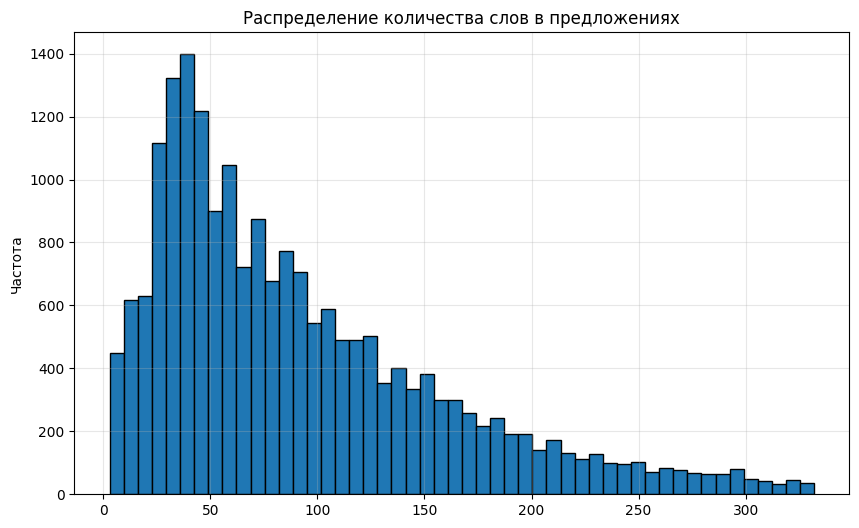

Filter:   0%|          | 0/180330 [00:00<?, ? examples/s]

Filter:   0%|          | 0/180330 [00:00<?, ? examples/s]

Filter:   0%|          | 0/180330 [00:00<?, ? examples/s]

In [6]:
# Рассчитываем порог длины по обучающей выборке
lengths = [len(text.split()) for text in dataset['train']['text']]       # Подсчет количества слов в каждом тексте обучающего набора.
max_len = np.percentile(lengths, 95)                                     # Определение 95-го процентиля для отсечения аномальных выбросов.

# Фильтруем ВЕСЬ объект DatasetDict (автоматически применится к train и validation)
dataset = dataset.filter(
    lambda x: 3 <= len(x['text'].split()) <= max_len
) # Удаление шума (короткие тексты) и слишком длинных сообщений.
# Лямбда-функция проверяет для каждого примера x: берет текст x['text'], разбивает на слова через split(), подсчитывает длину len() и проверяет условие 3 ≤ длина ≤ max_len; отсекается ~5% самых длинных текстов (т.к. max_len = 95-й перцентиль) и все тексты короче 3 слов (спам, смайлики, мусор)

# Подготовка данных для визуализации (используем оригинальный validation для анализа)
texts = dataset['validation']['text']                # Извлечение текстов для построения графика распределения.
word_counts = [len(text.split()) for text in texts]  # Расчет длин для визуальной проверки результатов фильтрации

plt.figure(figsize=(10, 6))                               # Инициализация окна графика с заданными пропорциями сторон.
plt.hist(word_counts, bins=50, edgecolor='black')         # Построение гистограммы распределения длин с разделением на 50 интервалов.
plt.title('Распределение количества слов в предложениях')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

# Формирование финальных обучающей и валидационной выборок
# Формируем сбалансированную обучающую подвыборку:по 10 000 примеров для каждого класса
train_neutral  = dataset['train'].filter(lambda x: x['sentiment'] == 0).select(range(10000))
train_positive = dataset['train'].filter(lambda x: x['sentiment'] == 1).select(range(10000))
train_negative = dataset['train'].filter(lambda x: x['sentiment'] == 2).select(range(10000))

train_dataset = concatenate_datasets([
    train_neutral,
    train_positive,
    train_negative
])

# Используем оригинальный validation-сплит датасета для итоговой оценки качества
valid_dataset = dataset['validation']

В связи с отсутствием отдельной тестовой выборки в исходном датасете, и не сложностью проекта, валидационная выборка используется как независимый набор для оценки качества и сравнения моделей.

## **Лемматизация и очистка текста**
Для базовых моделей классического машинного обучения реализован конвейер предварительной обработки текста, включающий:
Очистку от спецсимволов, цифр и латиницы с помощью регулярных выражений.
Токенизацию (разбиение на слова).
Удаление стоп-слов (предлогов, союзов), не влияющих на эмоциональную окраску.
Лемматизацию (приведение слов к нормальной форме) с использованием библиотеки pymorphy3.

Данный этап является кричиеским, обеспечивающим эффективность статистических методов анализа за счет целенаправленной минимизации признакового пространства. Очистка данных с помощью регулярных выражений и удаление стоп-слов позволяют существенно снизить уровень информационного шума и исключить лексемы, обладающие высокой частотностью при крайне низкой предсказательной способности. Ввиду значительной флективности русского языка применение лемматизации становится необходимым условием для унификации различных словоформ одного концепта, что предотвращает избыточное расширение признакового пространства и радикально снижает степень разреженности данных (sparsity). Таким образом, комплексный препроцессинг трансформирует неструктурированный текст в статистически плотное и значимое представление, позволяя классическим алгоритмам эффективно выявлять закономерности, определяющие эмоциональную окраску высказываний

In [7]:
print("Инициализация морфологического анализатора и паттернов...")
morph = pymorphy3.MorphAnalyzer()  # Инициализация морфологического анализатора русского языка для лемматизации


#Компиляция регулярных выражений (ускорение работы)
PAT_MENTION = re.compile(r'@\w+\b')                                 # Паттерн для удаления упоминаний пользователей (@username)
PAT_DIGIT = re.compile(r'\d+')                                      # Удаление чисел
PAT_NON_CYRILLIC = re.compile(r'[^а-яё\s]', flags=re.IGNORECASE)    # Удаление некириллических символов
PAT_WHITESPACE = re.compile(r'\s+')                                 # Нормализация пробелов


def preproc_optimized(text):
    if not isinstance(text, str):                         # Проверка типа входных данных
        return ""                                         # Защита от некорректных значений (None, NaN и т.п.)

    text = PAT_MENTION.sub(' ', text)                     # Удаление упоминаний пользователей
    text = PAT_DIGIT.sub(' ', text)                       # Удаление числовых последовательностей
    text = PAT_NON_CYRILLIC.sub(' ', text)                # Удаление символов, не относящихся к кириллице
    text = PAT_WHITESPACE.sub(' ', text).strip().lower()  # Нормализация пробелов, обрезка и приведение к нижнему регистру

    tokens = word_tokenize(text, language='russian')      # Токенизация текста на слова с учетом русского языка

    parse = morph.parse                            # Локальная ссылка на метод морфологического анализа (ускорение)
    stops = RUSSIAN_STOP_WORDS                     # Локальная ссылка на множество стоп-слов

    lemmas = [
        parse(token)[0].normal_form                # Приведение слова к нормальной форме (лемме)
        for token in tokens
        if len(token) >= 2 and token not in stops  # Фильтрация коротких токенов и стоп-слов
    ]

    return ' '.join(lemmas)                       # Возврат предобработанного текста в виде строки


#Применение предобработки к обучающему датасету
print("Запуск предобработки (Multiprocessing)...")

preproc_train_dataset = train_dataset.map(
    lambda x: {'text': preproc_optimized(x['text'])}, # Применение функции очистки и лемматизации к полю text
    num_proc=4,                                       # Использование 4 ядер CPU для ускорения обработки
    desc="Лемматизация"                               # Отображение прогресс-бара tqdm
)

#Применение предобработки к валидационному датасету
print("Запуск лемматизации валидационного набора...")

preproc_valid_dataset = valid_dataset.map(
    lambda x: {'text': preproc_optimized(x['text'])},
    num_proc=4,
    desc="Processing Valid"
)


train_texts = preproc_train_dataset['text']               # Извлечение предобработанных текстов в список
train_labels = list(preproc_train_dataset['sentiment'])   # Извлечение меток классов в список


valid_texts = list(preproc_valid_dataset['text'])
valid_labels = list(preproc_valid_dataset['sentiment'])


print(f"Обработано текстов: {len(train_texts)}")  # Вывод количества обработанных примеров


Инициализация морфологического анализатора и паттернов...
Запуск предобработки (Multiprocessing)...


Лемматизация (num_proc=4):   0%|          | 0/30000 [00:00<?, ? examples/s]

Запуск лемматизации валидационного набора...


Processing Valid (num_proc=4):   0%|          | 0/19936 [00:00<?, ? examples/s]

Обработано текстов: 30000


##Базовый метод: Bag of Words (BoW)

В качестве первого этапа экспериментов рассматривается применение классических методов обработки текстов и линейных моделей машинного обучения. Цель данного этапа — получить базовый ориентир качества и проверить, насколько задача анализа тональности решается без использования контекстных нейросетевых моделей. Для этого используется метод векторизации Bag of Words, реализованный с помощью CountVectorizer, который преобразует тексты в векторы частот слов, а в качестве классификатора применяется логистическая регрессия. Полученные результаты служат нижней границей качества и позволяют в дальнейшем обоснованно оценивать преимущества более сложных подходов, таких как контекстные эмбеддинги и трансформерные модели.

In [8]:
print("Создание векторов Bag of Words...")

# 1. Подготовка данных валидационной выборки
val_texts  = preproc_valid_dataset['text']                      # Тексты валидационной выборки
val_labels = list(preproc_valid_dataset['sentiment'])           # Метки классов валидационной выборки

# 2. Векторизация текста
bow_vectorizer = CountVectorizer(
    min_df=10,      # Учитываем только слова, встречающиеся минимум в 10 примерах (снижение шума и опечаток)
    max_df=0.9,     # Исключаем слова, встречающиеся более чем в 90% документов (слишком частые слова)
    binary=False    # Используем частоты слов, а не бинарное присутствие
)

bow_vectors_train = bow_vectorizer.fit_transform(train_texts)  # Обучение словаря на train
bow_vectors_val   = bow_vectorizer.transform(val_texts)        # Применение словаря к validation

print(f"Размер полученного словаря: {bow_vectors_train.shape[1]} слов")
# Вывод размера словаря Bag of Words

# 3. Обучение модели логистической регрессии
print("Обучение Logistic Regression...")

clf = LogisticRegression(
    max_iter=1000,  # Увеличиваем число итераций для гарантии сходимости оптимизации
    n_jobs=-1       # Используем все доступные ядра CPU для ускорения обучения
)

clf.fit(bow_vectors_train, train_labels)                # Обучение модели на обучающей выборке

# 4. Оценка качества модели
y_pred = clf.predict(bow_vectors_val)                   # Предсказания для валидационной выборки
accuracy = accuracy_score(val_labels, y_pred)           # Вычисление Accuracy на validation

print(f"Logistic Regression (BoW) Accuracy: {accuracy:.4f}")
# Вывод итоговой точности модели Bag of Words + Logistic Regression

Создание векторов Bag of Words...
Размер полученного словаря: 11570 слов
Обучение Logistic Regression...
Logistic Regression (BoW) Accuracy: 0.6830


Применение модели логистической регрессии к векторизованным текстовым данным позволило достичь точности классификации на уровне 68,30%, что свидетельствует о высокой эффективности реализованного конвейера предварительной обработки и адекватности выбранного статистического подхода. Полученный результат более чем в два раза превосходит порог случайного угадывания для трехклассовой задачи (33,3%), подтверждая способность классического алгоритма успешно выявлять линейные зависимости в лемматизированных признаках. Данный показатель устанавливает репрезентативный базовый уровень качества (baseline), при этом сохраняющийся разрыв до предельных значений точности подчеркивает фундаментальные ограничения частотных методов векторизации, не учитывающих сложные контекстуальные связи.

## **Наивный байесовский классификатор на мешке слов** Bernoulli Naive Bayes (Bag of Words)

В рамках продолжения анализа базовых подходов к задаче классификации тональности рассматривается наивный байесовский классификатор Bernoulli Naive Bayes. Данная модель относится к вероятностным линейным алгоритмам и ориентирована на работу с бинарными признаками, отражающими факт присутствия или отсутствия слов в тексте. Использование Bernoulli Naive Bayes в сочетании с представлением Bag of Words позволяет оценить эффективность ещё более простого статистического подхода и дополнительно зафиксировать нижнюю границу качества, с которой будут сравниваться результаты более сложных моделей.

In [9]:
print("Обучение Bernoulli Naive Bayes...")
nb = BernoulliNB(binarize=True)                # Инициализация Bernoulli Naive Bayes; признаки интерпретируются как бинарные (наличие/отсутствие слова)

nb.fit(bow_vectors_train, train_labels)        # Обучение модели на обучающей выборке, представленной в виде BoW-признаков

y_pred = nb.predict(bow_vectors_val)           # Получение предсказаний классов для валидационной выборки

accuracy = accuracy_score(val_labels, y_pred)  # Вычисление метрики Accuracy на оригинальной валидационной выборке

print(f"Bernoulli Naive Bayes (BoW) Accuracy: {accuracy:.4f}")   # Вывод итоговой точности модели Bernoulli Naive Bayes

Обучение Bernoulli Naive Bayes...
Bernoulli Naive Bayes (BoW) Accuracy: 0.5481


Полученный результат Accuracy: 54,81% оказался ниже, чем у логистической регрессии, что указывает на ограниченность предположений о независимости признаков и бинарной природе представления слов в контексте анализа тональности. Данный результат подтверждает, что, несмотря на простоту и высокую вычислительную эффективность, наивные байесовские модели уступают более гибким линейным классификаторам и используются в работе исключительно в качестве базового ориентира.

## **TF-IDF**
В данном этапе экспериментов используется метод TF-IDF, который, в отличие от Bag of Words, учитывает не только факт присутствия слов в тексте, но и их относительную информативность в корпусе документов. Это позволяет снизить влияние часто встречающихся, но малоинформативных слов и усилить вклад терминов, характерных для конкретных сообщений. TF-IDF векторизация применяется к обучающей выборке, после чего на полученных признаках обучаются линейные модели — наивный байесовский классификатор и логистическая регрессия. Цель данного этапа заключается в проверке того, насколько взвешенное представление слов улучшает качество классификации по сравнению с базовым частотным подходом

In [10]:
# 1. TF-IDF Векторизация
print("1. Создание TF-IDF векторов...")

tfidf_vectorizer = TfidfVectorizer(min_df=20, max_df=0.9)                        # Инициализация векторизатора с фильтрацией шума.
                                                                                 # Настройки: min_df=20 отсекает слишком редкие слова, повышая стабильность весов

# Обучаем на тренировочных леммах, трансформируем обе выборки
tfidf_vectors_train = tfidf_vectorizer.fit_transform(train_texts)                # Обучение модели весов и трансформация трейна.
tfidf_vectors_val   = tfidf_vectorizer.transform(val_texts)                      # Применение весов к независимому валидационному набору.

print(f"Размерность матрицы признаков: {tfidf_vectors_train.shape}")


#  Модель 1: Naive Bayes (Bernoulli)
print("\n3. Обучение Naive Bayes на TF-IDF...")                                  # Переход к вероятностному моделированию.
nb_tfidf = BernoulliNB(binarize=0.0)                                             # Инициализация Байесовского классификатора.
nb_tfidf.fit(tfidf_vectors_train, train_labels)                                  # Обучение на взвешенных признаках.

acc_nb_tfidf = accuracy_score(val_labels, nb_tfidf.predict(tfidf_vectors_val))   # Расчет точности на валидации.
print(f"-> Naive Bayes TF-IDF Accuracy: {acc_nb_tfidf:.4f}")                     # Вывод результата для сравнения с BoW-версией.

# Модель 2: Logistic Regression
print("\n4. Обучение Logistic Regression на TF-IDF...")                          # Переход к линейному классификатору.
clf_tfidf = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)        # Создание модели с параллельными вычислениями.
clf_tfidf.fit(tfidf_vectors_train, train_labels)                                 # Обучение логистической регрессии.

acc_lr_tfidf = accuracy_score(val_labels, clf_tfidf.predict(tfidf_vectors_val))  # Проверка предсказательной способности на тесте.
print(f"-> LogReg TF-IDF Accuracy: {acc_lr_tfidf:.4f}")                          # Итоговая точность метода TF-IDF

1. Создание TF-IDF векторов...
Размерность матрицы признаков: (30000, 7342)

3. Обучение Naive Bayes на TF-IDF...
-> Naive Bayes TF-IDF Accuracy: 0.6058

4. Обучение Logistic Regression на TF-IDF...
-> LogReg TF-IDF Accuracy: 0.7092


ВКР
Custom Gem
В результате применения метода векторизации TF-IDF была сформирована разреженная матрица признаков размерности (30000, 7342), что позволило существенно оптимизировать признаковое пространство и сфокусировать внимание алгоритмов на статистически значимых лексемах. Апробация вероятностного классификатора Bernoulli Naive Bayes показала точность на уровне 60,58%, подтвердив работоспособность подхода, однако наиболее репрезентативный результат среди классических методов продемонстрировала логистическая регрессия, достигнув показателя точности 70,92%. Данное значение свидетельствует о высокой эффективности использования взвешенных частотных характеристик для выявления эмоциональной окраски текстов в линейно разделимом пространстве, устанавливая при этом качественный порог для базовых решений и подтверждая целесообразность использования полученной модели в качестве сильного опорного результата для последующего сравнительного анализа с более продвинутыми архитектурами

## Word2Vec: распределённые эмбеддинги и линейная классификация

На данном этапе экспериментов рассматривается подход, основанный на обучении распределённых векторных представлений слов с использованием модели Word2Vec. В отличие от Bag of Words и TF-IDF, данный метод позволяет учитывать семантическую близость слов за счёт обучения эмбеддингов в безнадзорном режиме на обучающей выборке. Полученные векторы слов агрегируются в фиксированное представление текста и используются в качестве признаков для последующей классификации с помощью логистической регрессии. Цель данного этапа — оценить, насколько статические распределённые эмбеддинги улучшают качество классификации по сравнению с классическими частотными методами.

In [11]:
# Word2Vec + Logistic Regression
print("Подготовка предложений...")
sentences = [text.split() for text in preproc_train_dataset['text']]    # Разбиение очищенных текстов train на токены

print("Обучение Word2Vec...")
w2v_model = Word2Vec(            # Инициализация модели Word2Vec
    sentences=sentences,         # Корпус предложений из обучающей выборки
    vector_size=100,             # Размерность векторных представлений слов
    window=5,                    # Размер окна контекста (учет соседних слов)
    min_count=10,                # Игнорируем слова, встречающиеся реже 10 раз
    workers=4,                   # Использование 4 потоков CPU
    epochs=10                    # Количество эпох обучения
)

def vectorize_sum(text, model, max_length=60):                         # Функция преобразования текста в матрицу эмбеддингов
    embedding_dim = model.vector_size                                  # Размерность эмбеддингов Word2Vec
    features = np.zeros((max_length, embedding_dim), dtype='float32')  # Инициализация матрицы признаков нулями

    words = text.split()[:max_length]     # Ограничение длины текста первыми max_length словами

    for i, word in enumerate(words):      # Итерация по словам текста
        if word in model.wv:              # Проверка наличия слова в словаре Word2Vec
            features[i] = model.wv[word]  # Заполнение строки соответствующим эмбеддингом

    return features                       # Возврат матрицы (max_length × embedding_dim)

print("Создание векторов для обучающей выборки...")
X_wv_train = np.stack([                             # Формирование тензора признаков для train
    vectorize_sum(text, w2v_model)
    for text in tqdm(preproc_train_dataset['text'], desc="Train векторизация")
])

print("Создание векторов для валидационной выборки...")

X_wv_val = np.stack([                                  # Формирование тензора признаков для validation
    vectorize_sum(text, w2v_model)                     # Преобразование текста в матрицу эмбеддингов
    for text in tqdm(preproc_valid_dataset['text'],    # Итерация по текстам validation-выборки
                     desc="Validation векторизация")   # Прогресс-бар процесса
])

X_wv_train_flat = X_wv_train.reshape(X_wv_train.shape[0], -1)  # Преобразование (N, 60, 100) → (N, 6000)
X_wv_val_flat   = X_wv_val.reshape(X_wv_val.shape[0], -1)      # Аналогичное преобразование для validation

print("Обучение Logistic Regression на эмбеддингах...")        # Сообщение о начале обучения классификатора
clf = LogisticRegression(max_iter=1000, n_jobs=-1)             # Инициализация логистической регрессии
clf.fit(X_wv_train_flat, train_labels)                         # Обучение модели на обучающей выборке

y_pred = clf.predict(X_wv_val_flat)                            # Предсказания классов для validation
acc = accuracy_score(list(preproc_valid_dataset['sentiment']), y_pred)  # Вычисление Accuracy на валидационной выборке

print(f"Word2Vec + LogReg Accuracy: {acc:.4f}")                # Вывод итоговой точности модели


Подготовка предложений...
Обучение Word2Vec...
Создание векторов для обучающей выборки...


Train векторизация:   0%|          | 0/30000 [00:00<?, ?it/s]

Создание векторов для валидационной выборки...


Validation векторизация:   0%|          | 0/19936 [00:00<?, ?it/s]

Обучение Logistic Regression на эмбеддингах...
Word2Vec + LogReg Accuracy: 0.5897


Реализация метода агрегации Word2Vec-эмбеддингов для векторизации текстового корпуса позволила обучить модель логистической регрессии, продемонстрировавшую точность 58,97% на валидационной выборке. Хотя данный показатель существенно превосходит порог случайного распределения классов, он остается заметно ниже результатов, достигнутых с применением частотных методов векторизации TF-IDF. Подобная динамика объясняется нивелированием синтаксической структуры и специфических контекстуальных связей при использовании операций простого усреднения векторов слов, что подтверждает недостаточную репрезентативность неконтекстных нейросетевых эмбеддингов для фиксации тонких семантических нюансов эмоциональной окраски. Полученные экспериментальные данные служат эмпирическим обоснованием необходимости внедрения более сложных архитектур на основе механизмов внимания и глубокого обучения для качественного повышения точности классификации.

###Подготовка данных для нейронной сети Transformer
На данном этапе выполняется финальная подготовка входных данных для обучения кастомной трансформерной модели. Формируется словарь токенов на основе обучающей выборки, после чего создаются объекты Dataset и DataLoader, обеспечивающие корректную подачу данных в модель с учётом усечения, паддинга и пакетной обработки. Данный шаг необходим для эффективного и воспроизводимого обучения нейросетевой архитектуры в среде PyTorch.

In [12]:
# 1. Гиперпараметры и конфигурация модели

MAX_LEN = 256        # Максимальная длина последовательности выбрана на основе анализа распределения длин текстов (95-й перцентиль);
                     # позволяет сохранить большую часть информативного контента и одновременно ограничить вычислительную сложность

EMBED_DIM = 256      # Размерность эмбеддингов токенов выбрана как компромисс между выразительной способностью модели
                     # и вычислительными затратами; значение 256 достаточно для кодирования семантики слов в задаче тональности

NHEAD = 8            # Количество голов self-attention выбрано для обеспечения параллельного захвата различных
                     # типов контекстных зависимостей; 8 голов является стандартным и устойчивым значением для EMBED_DIM=256

FFN_HID_DIM = 256    # Размер скрытого слоя feed-forward сети установлен равным размерности эмбеддингов,
                     # что обеспечивает баланс между нелинейной выразительностью и стабильностью обучения

NUM_LAYERS = 4       # Количество encoder-слоёв трансформера выбрано для моделирования достаточно глубоких контекстных зависимостей,
                     # при этом не приводит к чрезмерному росту времени обучения и риску переобучения

BATCH_SIZE = 256     # Размер батча установлен на 256 с учётом возможностей GPU NVIDIA T4;
                     # крупный батч повышает стабильность градиентов и ускоряет обучение без превышения лимитов памяти

EPOCHS = 10          # Количество эпох обучения ограничено для предотвращения переобучения;
                     # значение выбрано эмпирически как достаточное для сходимости модели на данной выборке

LR = 1e-4            # Скорость обучения выбрана как стандартное значение для обучения трансформеров с нуля;
                     # обеспечивает устойчивую оптимизацию без резких скачков функции потерь

num_classes = 3      # Количество классов соответствует постановке задачи анализа тональности
                     # ( NEUTRAL, POSITIVE, NEGATIVE)

# 2. Создание словаря (Vocabulary)

def build_vocab(texts, min_df=2):        # Функция построения словаря по обучающим текстам
    vectorizer = CountVectorizer(
        min_df=min_df,                   # Игнорируем слишком редкие слова
        tokenizer=lambda x: x.split(),   # Токенизация по пробелам (текст уже предобработан)
        token_pattern=None               # Отключаем встроенный regex-tokenizer
    )
    vectorizer.fit(texts)                # Обучение словаря на train-текстах

    vocab = {word: idx + 2 for idx, word in # Формирование словаря сдвигом индексов
             enumerate(vectorizer.get_feature_names_out())}
    vocab['<pad>'] = 0                      # Специальный токен паддинга
    vocab['<unk>'] = 1                      # Токен неизвестного слова
    return vocab

print("Построение словаря...")

vocab = build_vocab(preproc_train_dataset['text']) # Построение словаря ТОЛЬКО по обучающей выборке
VOCAB_SIZE = len(vocab)                    # Размер словаря
print(f"Размер словаря: {VOCAB_SIZE}")     # Вывод размера словаря


# 3. Класс Dataset для PyTorch
class CommentDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len): # Инициализация датасета
        self.texts = texts                             # Список текстов
        self.labels = labels                           # Список меток классов
        self.vocab = vocab                             # Словарь токенов
        self.max_len = max_len                         # Максимальная длина последовательности
        self.unk_idx = vocab['<unk>']                  # Индекс unknown-токена
        self.pad_idx = vocab['<pad>']                  # Индекс padding-токена

    def __len__(self):
        return len(self.texts)                         # Количество примеров в датасете

    def __getitem__(self, idx):
        tokens = self.texts[idx].split()               # Разбиение текста на токены

        token_ids = [self.vocab.get(t, self.unk_idx)   # Преобразование токенов в индексы
                     for t in tokens[:self.max_len]]   # Усечение до MAX_LEN

        if len(token_ids) < self.max_len:                                 # Если длина меньше MAX_LEN
            token_ids += [self.pad_idx] * (self.max_len - len(token_ids)) # Дополнение padding-токенами

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),       # Тензор индексов токенов
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)    # Тензор метки класса
        }


# 4. Подготовка DataLoader
print("Подготовка DataLoader...")

train_data = CommentDataset(            # Датасет для обучения
    list(preproc_train_dataset['text']),
    list(preproc_train_dataset['sentiment']),
    vocab,
    MAX_LEN
)

val_data = CommentDataset(              # Датасет для валидации
    list(preproc_valid_dataset['text']),
    list(preproc_valid_dataset['sentiment']),
    vocab,
    MAX_LEN
)

train_loader = DataLoader(  # DataLoader для обучения
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Перемешивание данных на каждой эпохе
    num_workers=0,          # Отключаем multiprocessing при загрузке данных, чтобы избежать ошибок завершения процессов и обеспечить стабильную работу DataLoader в среде Jupyter/Cola
    pin_memory=True         # Ускорение передачи данных на GPU
)


val_loader = DataLoader(    # DataLoader для валидации
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Без перемешивания для оценки
    num_workers=0,
    pin_memory=True
)

print(f"Готово. Батчей в train: {len(train_loader)}, "
      f"в val: {len(val_loader)}")   # Контроль количества батчей


Построение словаря...
Размер словаря: 35041
Подготовка DataLoader...
Готово. Батчей в train: 118, в val: 78


В результате построения словаря было получено 35 041 уникальных токенов, что отражает высокое лексическое разнообразие русскоязычных текстов в обучающей выборке даже после предварительной фильтрации и нормализации. Словарь сформирован исключительно на обучающих данных, что исключает утечку информации из валидационной выборки.

После подготовки DataLoader сформировано 118 батчей для обучающей выборки и 78 батчей для валидационной выборки при заданном размере батча. Это подтверждает корректное разбиение данных и готовность конвейера к обучению модели.

###Реализация архитектуры Transformer «с нуля»
В данном блоке реализуются ключевые компоненты трансформерной архитектуры вручную с использованием библиотеки PyTorch. Последовательно описываются модули многоголового механизма самовнимания, encoder-блок, позиционное кодирование и итоговая модель классификации текста. Цель данного этапа — наглядно продемонстрировать внутреннее устройство трансформера и обеспечить полный контроль над архитектурой модели, используемой для решения задачи анализа тональности, без применения готовых высокоуровневых реализаций.

А также инициализация модели, оптимизатора и функции потерь.

In [13]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0             # Проверка кратности размерности количеству голов внимания.
        self.hid_dim = hid_dim                    # Общая размерность скрытого пространства.
        self.n_heads = n_heads                    # Количество параллельных голов внимания.
        self.head_dim = hid_dim // n_heads        # Размерность вектора для каждой отдельной головы.

        # Линейные слои для формирования векторов
        self.fc_q = nn.Linear(hid_dim, hid_dim)  # Query (запрос).
        self.fc_k = nn.Linear(hid_dim, hid_dim)  # Key (ключ).
        self.fc_v = nn.Linear(hid_dim, hid_dim)  # Value (значение).
        self.fc_o = nn.Linear(hid_dim, hid_dim)  # Выходной линейный слой для объединения результатов голов.

        self.dropout = nn.Dropout(dropout)       # Слой регуляризации для предотвращения переобучения.
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device) # Масштабирующий коэффициент для стабилизации градиентов.

    def forward(self, query, key, value):
        batch_size = query.shape[0]        # Получение размера текущего пакета данных.

        Q = self.fc_q(query)               # Проецирование входных данных в пространство запросов.
        K = self.fc_k(key)                 # Проецирование входных данных в пространство ключей.
        V = self.fc_v(value)               # Проецирование входных данных в пространство значений.

        # Разделение признаков по головам и изменение порядка осей для вычислений
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Вычисление энергии внимания (скалярное произведение Q и K)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        attention = torch.softmax(energy, dim=-1)       # Нормализация весов внимания через функцию Softmax.
        x = torch.matmul(self.dropout(attention), V)    # Взвешенное суммирование векторов Value.

        x = x.permute(0, 2, 1, 3).contiguous()          # Обратная перестановка осей.
        x = x.view(batch_size, -1, self.hid_dim)        # Объединение (конкатенация) результатов всех голов.
        x = self.fc_o(x)                                # Финальная линейная проекция.
        return x, attention

class EncoderBlock(nn.Module):
    def __init__(self, emb_size, nhead, dim_feedforward=128, dropout=0.2):
        super().__init__()
        self.self_attn = MultiHeadAttentionLayer(emb_size, nhead, dropout, device=device) # Слой самовнимания.
        self.linear1 = nn.Linear(emb_size, dim_feedforward)              # Первый слой блока Feed-Forward.
        self.linear2 = nn.Linear(dim_feedforward, emb_size)              # Второй слой блока Feed-Forward.
        self.norm1 = nn.LayerNorm(emb_size)                              # Слой нормализации после внимания.
        self.norm2 = nn.LayerNorm(emb_size)                              # Слой нормализации после полносвязной сети.
        self.dropout = nn.Dropout(dropout)                               # Регуляризация между слоями.
        self.activation = nn.ReLU()                                      # Нелинейная функция активации.

    def forward(self, src):
        src2, _ = self.self_attn(src, src, src)                          # Применение механизма самовнимания.
        src = self.norm1(src + self.dropout(src2))                       # Сложение с остаточной связью и нормализация.

        src2 = self.linear2(self.dropout(self.activation(self.linear1(src)))) # Проход через блок Feed-Forward.
        src = self.norm2(src + self.dropout(src2))                       # Вторая остаточная связь и нормализация.
        return src

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, max_len):
        super().__init__()
        pe = torch.zeros(max_len, emb_size)                              # Инициализация матрицы позиционных признаков.
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # Создание вектора индексов позиций.
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size)) # Коэффициенты для синусоид.
        pe[:, 0::2] = torch.sin(position * div_term)                     # Вычисление синуса для четных индексов.
        pe[:, 1::2] = torch.cos(position * div_term)                     # Вычисление косинуса для нечетных индексов.
        pe = pe.unsqueeze(0)                                             # Добавление размерности батча.
        self.register_buffer('pe', pe)                                   # Сохранение в буфер (не обучаемый параметр).

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]                                # Сложение эмбеддингов слов с позиционными метками.

class TextTransformer(nn.Module):
    def __init__(self, num_classes, vocab_size, emb_size, nhead, num_layers, dim_feedforward, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)              # Слой векторного представления слов (Lookup table).
        self.pos_encoder = PositionalEncoding(emb_size, MAX_LEN)         # Модуль учета позиций токенов.
        self.layers = nn.ModuleList([
            EncoderBlock(emb_size, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])                                                               # Стек из последовательных блоков энкодера.
        self.classifier = nn.Linear(emb_size, num_classes)               # Полносвязный слой для предсказания финального класса.

    def forward(self, src):
        src = self.embedding(src)       # Преобразование индексов слов в плотные векторы.
        src = self.pos_encoder(src)     # Добавление позиционной информации.

        for layer in self.layers:
            src = layer(src)            # Последовательная обработка в слоях энкодера.

        output = src.mean(dim=1)        # Глобальное усреднение по длине (Global Average Pooling).
        return self.classifier(output)  # Вычисление логитов для трех классов.


#Инициализация модели и оптимизатора
model = TextTransformer(         # Создание экземпляра кастомной трансформерной модели
    num_classes=num_classes,     # Количество выходных классов (тональности)
    vocab_size=VOCAB_SIZE,       # Размер словаря (количество уникальных токенов)
    emb_size=EMBED_DIM,          # Размерность эмбеддингов токенов
    nhead=NHEAD,                 # Количество голов self-attention
    num_layers=NUM_LAYERS,       # Количество encoder-слоёв трансформера
    dim_feedforward=FFN_HID_DIM  # Размер скрытого слоя feed-forward сети
).to(device)                     # Перенос модели на CPU или GPU

optimizer = optim.AdamW(         # Инициализация оптимизатора AdamW
    model.parameters(),          # Параметры модели, которые будут обучаться
    lr=LR                        # Скорость обучения
)

criterion = nn.CrossEntropyLoss()# Функция потерь для многоклассовой классификации

scaler = GradScaler()            # GradScaler для Mixed Precision (FP16) обучения

# Вывод архитектуры модели в текстовом виде
summary(                       # Вызов функции анализа архитектуры нейросетевой модели
    model,                     # Экземпляр обучаемой модели Transformer, архитектура которой анализируется
    input_size=(1, MAX_LEN),   # Размер входного тензора: 1 пример (batch size) длиной MAX_LEN токенов
    dtypes=[torch.long]        # Тип входных данных — целочисленные индексы токенов для embedding-слоя
)

Layer (type:depth-idx)                        Output Shape              Param #
TextTransformer                               [1, 3]                    --
├─Embedding: 1-1                              [1, 256, 256]             8,970,496
├─PositionalEncoding: 1-2                     [1, 256, 256]             --
├─ModuleList: 1-3                             --                        --
│    └─EncoderBlock: 2-1                      [1, 256, 256]             --
│    │    └─MultiHeadAttentionLayer: 3-1      [1, 256, 256]             263,168
│    │    └─Dropout: 3-2                      [1, 256, 256]             --
│    │    └─LayerNorm: 3-3                    [1, 256, 256]             512
│    │    └─Linear: 3-4                       [1, 256, 256]             65,792
│    │    └─ReLU: 3-5                         [1, 256, 256]             --
│    │    └─Dropout: 3-6                      [1, 256, 256]             --
│    │    └─Linear: 3-7                       [1, 256, 256]             65,792

Визуализация архитектуры модели с использованием библиотеки torchinfo показала, что кастомная трансформерная модель содержит 10,55 млн обучаемых параметров. Как и предполагалось, основная часть весов (около 85%) приходится на слой эмбеддингов слов (8,97 млн параметров), что характерно для моделей, работающих с широким словарем. Архитектура включает в себя четыре идентичных encoder-блока, каждый из которых содержит механизм многоголового самовнимания и полносвязную сеть (feed-forward). Общий расчетный объем модели в памяти составляет 59,52 МБ, что подтверждает её легковесность и высокую скорость обработки данных по сравнению с более глубокими SOTA-решениями.

###Обучение кастомной модели Transformer
В данной ячейке реализуется полный цикл обучения кастомной трансформерной модели для задачи анализа тональности текста. Процесс обучения включает обучение на сбалансированной обучающей выборке с использованием смешанной точности вычислений (Mixed Precision), оценку качества на независимой валидационной выборке, а также механизм ранней остановки и сохранения лучших весов модели. Такой подход позволяет обеспечить стабильное обучение, контролировать переобучение и получить воспроизводимые результаты.

In [14]:
# 1. Настройки цикла обучения
patience = 3                     # Сколько эпох ждать улучшения перед ранней остановкой
best_val_acc = 0                 # Лучшая достигнутая точность на validation
patience_counter = 0             # Счётчик эпох без улучшения

print(f"Начинаем обучение на {device} с использованием Mixed Precision...")


#Подготовка структуры для логов
history = {                      # Заводим пустой логбук для записи истории
    'train_loss': [],            # Сюда будем скидывать средний лосс по эпохам
    'train_acc': [],             # Здесь будем хранить точность на трейне (%)
    'val_loss': [],              # Добавляем пустой список для лосса валидации
    'val_acc': []                # И точность на валидации для сравнения
}


# 2. Основной цикл обучения по эпохам
for epoch in range(EPOCHS):      # Цикл по эпохам обучения
    # TRAIN
    model.train()                # Перевод модели в режим обучения
    total_loss = 0               # Суммарная потеря за эпоху
    correct = 0                  # Количество верных предсказаний
    total = 0                    # Общее количество примеров

    progress_bar = tqdm(         # Прогресс-бар для обучения
        train_loader,
        desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"
    )

    for batch in progress_bar:                             # Итерация по батчам обучающей выборки
        input_ids = batch['input_ids'].to(device)          # Входные токены (индексы слов)
        labels = batch['labels'].to(device)                # Истинные метки классов

        optimizer.zero_grad()                              # Обнуление градиентов перед шагом обучения

        with autocast():                                   # Включение автоматической смешанной точности (FP16)
            outputs = model(input_ids)                     # Прямой проход модели (логиты)
            loss = criterion(outputs, labels)              # Вычисление функции потерь

        scaler.scale(loss).backward()                      # Масштабирование лосса и вычисление градиентов
        scaler.step(optimizer)                             # Шаг оптимизации с учётом масштабирования
        scaler.update()                                    # Обновление scaler для следующей итерации

        total_loss += loss.item()                          # Накопление значения лосса
        preds = torch.argmax(outputs, dim=1)               # Получение предсказанных классов
        correct += (preds == labels).sum().item()          # Подсчёт верных предсказаний
        total += labels.size(0)                            # Увеличение счётчика примеров

        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': correct / total
        })

    train_acc = 100 * correct / total                      # Accuracy на обучающей выборке (в процентах)
    avg_loss = total_loss / len(train_loader)              # Среднее значение лосса за эпоху

    # VALIDATION
    model.eval()                                           # Перевод модели в режим оценки
    val_correct = 0                                        # Верные предсказания на validation
    val_total = 0                                          # Общее количество validation-примеров
    val_running_loss = 0                                   # Счетчик для накопления лосса

    with torch.no_grad():                                  # Отключение вычисления градиентов
        for batch in val_loader:                           # Итерация по батчам валидационной выборки
            input_ids = batch['input_ids'].to(device)      # Входные данные
            labels = batch['labels'].to(device)            # Истинные метки

            outputs = model(input_ids)                     # Прямой проход модели
            loss = criterion(outputs, labels)              # считаем лосс
            val_running_loss += loss.item()                # Плюсуем в общую копилку за эпоху
            predicted = torch.argmax(outputs, dim=1)       # Предсказанные классы

            val_correct += (predicted == labels).sum().item()  # Подсчёт верных ответов
            val_total += labels.size(0)                        # Подсчёт количества примеров

    val_acc = 100 * val_correct / val_total if val_total > 0 else 0  # Accuracy на validation
    avg_val_loss = val_running_loss / len(val_loader)                # Считаем средний лосс валидации

    print(f"Epoch {epoch+1} Result: "
          f"Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} |"
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    history['train_loss'].append(avg_loss)     # Записываем средний лосс за прошедшую эпоху
    history['train_acc'].append(train_acc)     # Фиксируем, как хорошо модель выучила трейн
    history['val_loss'].append(avg_val_loss)                               # ТЕПЕРЬ ЗАПИСЫВАЕМ VAL LOSS
    history['val_acc'].append(val_acc)         # Чекаем реальный прогресс на проверочных данных

    # Ранняя остановка
    if val_acc > best_val_acc:                             # Если качество улучшилось
        best_val_acc = val_acc                             # Обновляем лучшее значение accuracy
        patience_counter = 0                               # Сбрасываем счётчик ожидания
        torch.save(model.state_dict(),                     # Сохраняем веса лучшей модели
                   "best_custom_transformer.pth")
    else:
        patience_counter += 1                              # Увеличиваем счётчик без улучшения
        if patience_counter >= patience:                   # Если превышен порог ожидания
            print(f"\nРанняя остановка! "
                  f"Точность не растет {patience} эпохи.")
            print(f"Лучшая Val Acc: {best_val_acc:.2f}%")
            break


# 3. Загрузка лучших весов
model.load_state_dict(
    torch.load("best_custom_transformer.pth")
)


Начинаем обучение на cuda с использованием Mixed Precision...


Epoch 1/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1 Result: Loss: 1.0037 | Val Loss: 0.8124 |Train Acc: 46.25% | Val Acc: 60.07%


Epoch 2/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2 Result: Loss: 0.7770 | Val Loss: 0.7137 |Train Acc: 63.68% | Val Acc: 65.20%


Epoch 3/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3 Result: Loss: 0.6898 | Val Loss: 0.7342 |Train Acc: 68.30% | Val Acc: 64.82%


Epoch 4/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4 Result: Loss: 0.6323 | Val Loss: 0.7339 |Train Acc: 71.49% | Val Acc: 65.51%


Epoch 5/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5 Result: Loss: 0.5923 | Val Loss: 0.6433 |Train Acc: 73.28% | Val Acc: 69.87%


Epoch 6/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6 Result: Loss: 0.5567 | Val Loss: 0.7235 |Train Acc: 75.30% | Val Acc: 66.58%


Epoch 7/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7 Result: Loss: 0.5213 | Val Loss: 0.7082 |Train Acc: 77.01% | Val Acc: 67.90%


Epoch 8/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8 Result: Loss: 0.4922 | Val Loss: 0.6578 |Train Acc: 78.31% | Val Acc: 71.32%


Epoch 9/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 9 Result: Loss: 0.4592 | Val Loss: 0.7375 |Train Acc: 80.21% | Val Acc: 68.66%


Epoch 10/10 [Train]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 10 Result: Loss: 0.4244 | Val Loss: 0.7512 |Train Acc: 81.62% | Val Acc: 69.44%


<All keys matched successfully>

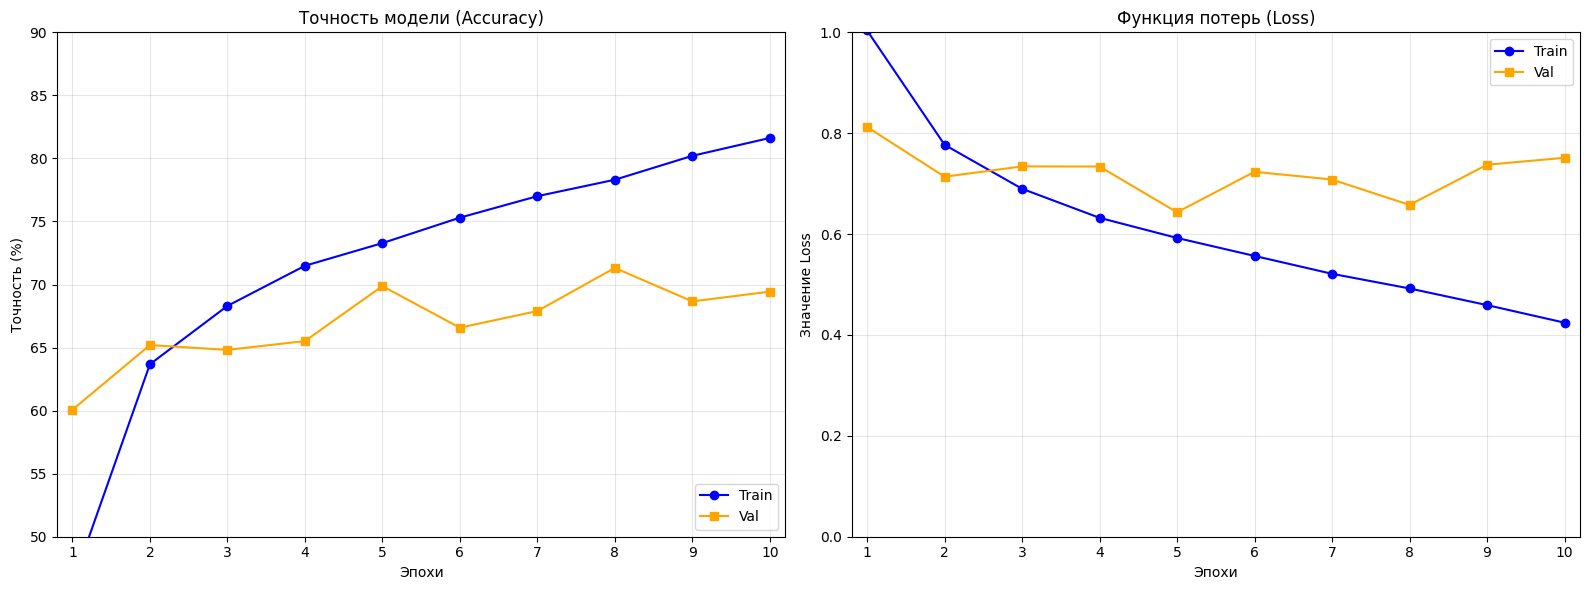

In [15]:
# Функция отрисовки графиков
def plot_training_history(history):                                         # Запуск визуализации итогов обучения
    epochs = range(1, len(history['train_acc']) + 1)                        # Создаем шкалу эпох (1, 2, 3...)
    plt.figure(figsize=(16, 6))                                             # Создаем широкое полотно для двух графиков

    # 1. График Accuracy (Точность)
    plt.subplot(1, 2, 1)                                                    # Левая секция: Accuracy
    plt.plot(epochs, history['train_acc'], 'blue', marker='o', label='Train') # Синяя линия — точность обучения
    plt.plot(epochs, history['val_acc'], 'orange', marker='s', label='Val') # Оранжевая линия — точность валидации

    plt.title('Точность модели (Accuracy)')                                 # Заголовок графика точности
    plt.xlabel('Эпохи'); plt.ylabel('Точность (%)')                         # Подписи горизонтальной и вертикальной осей
    plt.xticks(epochs)                                                      # Ставим только целые числа эпох на шкале X
    plt.xlim(0.8, len(epochs) + 0.2)                                        # Центрируем график, убирая пустоту
    plt.ylim(50, 90)                                                        # Фиксируем масштаб точности от 50 до 90
    plt.legend(loc='lower right'); plt.grid(True, alpha=0.3)                # Добавляем легенду и сетку

    # 2. График Loss (Потери)
    plt.subplot(1, 2, 2)                                                    # Правая секция: Loss
    plt.plot(epochs, history['train_loss'], 'blue', marker='o', label='Train') # Синяя линия — потери обучения
    plt.plot(epochs, history['val_loss'], 'orange', marker='s', label='Val') # Оранжевая линия — потери валидации

    plt.title('Функция потерь (Loss)')                                      # Заголовок графика потерь
    plt.xlabel('Эпохи'); plt.ylabel('Значение Loss')                        # Подписи осей для графика потерь
    plt.xticks(epochs)                                                      # Только целые числа на оси времени
    plt.xlim(0.8, len(epochs) + 0.2)                                        # Убираем лишние отступы по краям
    plt.ylim(0, 1)                                                          # Фиксируем масштаб лосса от 0 до 1
    plt.legend(loc='upper right'); plt.grid(True, alpha=0.3)               # Ставим легенду в угол и включаем сетку

    plt.tight_layout()                                                      # Оптимизируем расположение элементов
    plt.show()                                                              # Отрисовываем финальный результат

# Вызов функции
plot_training_history(history)                                              # Генерируем отчетные графики

Анализ результатов обучения кастомной архитектуры трансформера демонстрирует выраженную положительную динамику сходимости модели, при которой итоговый показатель точности на валидационной выборке достиг своего пика на 8-й эпохе, составив 71.32%. В процессе обучения наблюдалось стабильное снижение тренировочного лосса с 1.0037 до 0.4244, что свидетельствует об эффективном усвоении моделью закономерностей обучающего набора данных. Тем не менее, начиная с 9-й эпохи, зафиксировано расхождение между растущей точностью на обучении (81.62%) и стагнирующей метрикой на валидации, что в сочетании с ростом валидационного лосса до 0.7512 указывает на достижение предела обобщающей способности данной архитектуры и начало процесса переобучения. Таким образом, кастомная модель трансформера продемонстрировала конкурентоспособный результат, сопоставимый с сильным линейным бейзлайном (Logistic Regression на TF-IDF),

###Тестирование предобученных моделей **RuBERT base-cased и RuBERT base-cased-conversational** без дообучения
Для эксперимента выбраны модели DeepPavlov/rubert-base-cased и DeepPavlov/rubert-base-cased-conversational как общепризнанный стандарт для работы с русскими текстами, при этом англоязычные и многоязычные версии BERT не рассматривались из-за языковых различий и потери качества при распределении ресурсов модели между десятками языков, а сравнение стандартной версии с диалоговой при одинаковой архитектуре помогает понять влияние корпуса предобучения на качество классификации без дообучения и обосновать необходимость специализированного файнтюнинга под тексты студенческих обращений.

Выбор  этих двух моделей продиктован необходимостью обеспечения правовой прозрачности использования в рамках лицензии Apache 2.0, а также наличием обширной научно-технической документации, гарантирующей воспроизводимость и высокую степень интерпретируемости результатов. В условиях ограниченных вычислительных ресурсов данные архитектуры демонстрируют оптимальный баланс между скоростью обучения и качеством классификации, позволяя проводить глубокий Fine-tuning без избыточных аппаратных затрат. Использование данных моделей в рамках экосистемы Hugging Face формирует устойчивый технологический фундамент, который сохраняет возможность бесшовной миграции на более современные SOTA-архитектуры в будущем посредством минимальных изменений конфигурации, что подтверждает стратегическую обоснованность и гибкость выбранного инструментария.

Загрузка предобученных трансформерных моделей (RuBERT base-cased и RuBERT base-cased-conversational) и проверка их работы на задаче анализа тональности без этапа файнтюнинга позволяет продемонстрировать, что без дообучения классификационного слоя модели показывают результаты на уровне случайного угадывания, что подтверждает необходимость дальнейшей настройки под специфику задачи.

В отличие от baseline-моделей и кастомного Transformer, для тестирования предобученных RuBERT используются исходные тексты без лемматизации, удаления стоп-слов и приведения к нижнему регистру, поскольку трансформерные модели имеют принципиально иную архитектуру: их токенизатор обучался на живых текстах с естественной морфологией и способен самостоятельно обрабатывать словоформы, регистр букв несет смысловую нагрузку для регистрозависимой модели, стоп-слова играют важную роль для механизма внимания при анализе связей между словами.

In [16]:
# Извлечение данных из подготовленного ранее тестового набора
test_texts = valid_dataset['text']                                        # Список текстов бе зобработки для тестирования.
test_labels = valid_dataset['sentiment']                                  # Истинные метки классов для сопоставления с прогнозами.

def test_model(model_name, test_texts, test_labels, batch_size):         # Определение функции для оценки моделей без дообучения.
    try:                                                                 # Блок перехвата исключений для предотвращения остановки ядра.
        tokenizer = AutoTokenizer.from_pretrained(model_name)            # Загрузка токенизатора, специфичного для архитектуры модели.
        model = AutoModelForSequenceClassification.from_pretrained(      # Инициализация модели со случайными весами выходного слоя.
            model_name,                                                  # Путь к репозиторию модели на Hugging Face.
            num_labels=3,                                                # Конфигурация классификатора на три целевых класса.
        )
        model.to(device)                                                 # Перенос вычислительных весов модели в память GPU.
        model.eval()                                                     # Переключение модели в режим оценки (заморозка Dropout слоев).
        print("\n" + "=" * 80)
        print(f"Результат модели: {model_name}")
        print("=" * 80)
        predictions = []                                                 # Список для накопления предсказаний по батчам.

        for i in tqdm(range(0, len(test_texts), batch_size)):            # Итерация по данным с визуализацией прогресса выполнения.
            batch_texts = test_texts[i:i + batch_size]                   # Формирование пакета текстов для текущей итерации.

            inputs = tokenizer(         # Преобразование текста в тензорный формат для BERT.
                batch_texts,            # Пакет входных текстовых данных.
                padding=True,           # Динамическое дополнение до максимальной длины в батче.
                truncation=True,        # Обрезка текстов, превышающих лимит токенизатора.
                max_length=256,         # Ограничение максимальной длины последовательности.
                return_tensors="pt"     # Возврат результата в виде тензоров PyTorch.
            ).to(device)                # Отправка подготовленных данных на видеокарту.

            with torch.no_grad():                                        # Отключение расчета градиентов для минимизации расхода VRAM.
                outputs = model(**inputs)                                # Получение выходных логитов от предобученной модели.
                # Вычисление индекса наиболее вероятного класса (аргумент максимума)
                batch_predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
                predictions.extend(batch_predictions)                    # Сохранение результатов текущего батча в общий список.

        predictions = np.array(predictions)                              # Преобразование накопленного списка в массив NumPy.
        acc = accuracy_score(test_labels, predictions)                   # Вычисление общей доли правильных ответов (Accuracy).
        f1_m = f1_score(test_labels, predictions, average='macro')       # Расчет F1-меры без учета веса (Macro F1).
        f1_w = f1_score(test_labels, predictions, average='weighted')    # Расчет взвешенной F1-меры (Weighted F1).


        print(classification_report(                                     # Вывод детального аналитического отчета по классам.
            test_labels,                                                 # Список эталонных меток из датасета.
            predictions,                                                 # Метки, предсказанные нейронной сетью.
            target_names=['Нейтральный', 'Позитивный', 'Негативный'],    # Соответствие индексов семантике классов.
            digits=4                                                     # Установка точности отображения метрик (4 знака).
        ))

        return {                         # Формирование словаря с результатами эксперимента.
            'model': model_name,         # Имя протестированной архитектуры.
            'accuracy': acc,             # Итоговое значение метрики Accuracy.
            'f1_macro': f1_m,            # Итоговое значение метрики F1-macro.
            'f1_weighted': f1_w,         # Итоговое значение метрики F1-weighted.
            'predictions': predictions   # Сохраненный массив предсказаний для отчета.
        }

    except Exception as e:                     # Обработка возможных ошибок в процессе инференса.
        print(f"Ошибка в {model_name}: {e}")   # Вывод описания ошибки для диагностики.
        return None                            # Возврат пустого объекта в случае сбоя.

# Инициализация и запуск моделей
models = {                                                               # Определение перечня моделей для сравнительного анализа.
    "RuBERT": "DeepPavlov/rubert-base-cased",                            # Классическая архитектура RuBERT от DeepPavlov.
    "RuBERT на диалогах": "DeepPavlov/rubert-base-cased-conversational"  # Разговорная модель, обученная на данных из отзывов
}

results = {}   # Глобальный словарь для сбора итоговой статистики.

for model_label, model_name in models.items():                              # Автоматический запуск тестов для каждой модели в списке.
    result = test_model(model_name, test_texts, test_labels, batch_size=32) # Вызов функции тестирования для текущей итерации.
    if result:                                                              # Проверка успешности завершения эксперимента.
        results[model_label] = result                                       # Сохранение результатов в общий массив данных.

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Результат модели: DeepPavlov/rubert-base-cased


  0%|          | 0/623 [00:00<?, ?it/s]

              precision    recall  f1-score   support

 Нейтральный     0.3339    0.0403    0.0720      5133
  Позитивный     0.4454    0.0565    0.1003      9588
  Негативный     0.2650    0.9198    0.4115      5215

    accuracy                         0.2782     19936
   macro avg     0.3481    0.3389    0.1946     19936
weighted avg     0.3695    0.2782    0.1744     19936



tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Результат модели: DeepPavlov/rubert-base-cased-conversational


  0%|          | 0/623 [00:00<?, ?it/s]

              precision    recall  f1-score   support

 Нейтральный     0.3869    0.0666    0.1137      5133
  Позитивный     0.4888    0.9608    0.6480      9588
  Негативный     0.2126    0.0084    0.0162      5215

    accuracy                         0.4814     19936
   macro avg     0.3628    0.3453    0.2593     19936
weighted avg     0.3903    0.4814    0.3452     19936



Результаты показывают, что без fine-tuning предобученные RuBERT-модели демонстрируют сильное смещение в сторону одного класса и не способны корректно различать тональность. Это подтверждает, что предобучение языковой модели не заменяет обучение классификационной головы под конкретную прикладную задачу.

## **Квантованные версии моделей**

Использование 8-битного квантования обеспечивает четырехкратную экономию видеопамяти, необходимой для хранения весов модели, за счет перехода от стандартного 32-битного представления с плавающей точкой к компактному целочисленному формату. В практическом эквиваленте это позволяет сократить объем памяти, занимаемый параметрами модели архитектуры RuBERT, с исходных 480 МБ до приблизительно 120 МБ, что критически расширяет возможности обучения на оборудовании с ограниченными ресурсами. При столь существенной оптимизации аппаратных затрат потери в точности классификации носят минимальный характер и в большинстве случаев не превышают 1–2%, что является статистически допустимой погрешностью на фоне достигаемого выигрыша в скорости обработки данных и снижении требований к VRAM. Таким образом, квантование позволяет сохранять высокую обобщающую способность трансформера, делая его эксплуатацию технически доступной и экономически обоснованной.

###Проверка работы квантованных моделей (8-bit)


Тестирование возможности загрузки больших языковых моделей (LLM) в режиме 8-битного квантования с использованием библиотеки bitsandbytes. Это технический этап, подтверждающий возможность запуска моделей на доступном оборудовании (GPU с ограниченной памятью) перед началом процесса дообучения.

In [17]:
# 1. Функция тестирования
def test_quantized_model(model_name, test_texts, test_labels, batch_size=256):      # Функция для оценки предобученной трансформерной модели в режиме 8-битного квантования
    try:
        # Конфиг для 8-битной загрузки (экономит память)
        quantization_config = BitsAndBytesConfig(                                    # Конфигурация квантования модели с использованием библиотеки bitsandbytes
            load_in_8bit=True,                                                       # Включение 8-битного квантования весов модели
            llm_int8_threshold=6.0,                                                  # Оставляем "выбросы" выше 6.0 в 16-битах, чтобы не убить точность модели
            llm_int8_skip_modules=None,                                              # Квантование всех модулей без исключений
            llm_int8_has_fp16_weight=False                                           # Отсутствие FP16-копии весов (экономия памяти)
        )

        tokenizer = AutoTokenizer.from_pretrained(model_name)                        # Загрузка токенизатора, соответствующего выбранной модели
        model = AutoModelForSequenceClassification.from_pretrained(                  # Загрузка модели классификации последовательностей
            model_name,                                                              # Идентификатор модели на Hugging Face Hub
            num_labels=3,                                                            # Количество классов тональности
            quantization_config=quantization_config,                                 # Передача конфигурации 8-битного квантования
            device_map="auto",                                                       # Автоматическое распределение модели по доступным устройствам
            ignore_mismatched_sizes=True                                             # Игнорирование несовпадений размеров классификационной головы
        )
        model.eval()                                                                 # Перевод модели в режим инференса (отключение dropout)

        predictions = []                                                             # Список для накопления предсказанных классов

        # Предсказание батчами
        for i in tqdm(range(0, len(test_texts), batch_size), desc="Testing"):        # Итерация по тестовым данным батчами с отображением прогресса
            batch_texts = test_texts[i:i + batch_size]                               # Выбор текущего батча текстов

            inputs = tokenizer(                                                      # Токенизация батча текстов
                batch_texts,                                                         # Список текстов для токенизации
                padding=True,                                                        # Выравнивание длины последовательностей
                truncation=True,                                                     # Усечение длинных текстов
                max_length=256,                                                      # Максимальная длина входной последовательности
                return_tensors="pt"                                                  # Возврат результата в виде PyTorch-тензоров
            )
            inputs = {k: v.to(model.device) for k, v in inputs.items()}              # Перенос входных тензоров на устройство модели

            with torch.no_grad():                                                    # Отключение вычисления градиентов для ускорения инференса
                outputs = model(**inputs)                                            # Прямой проход модели
                preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()           # Получение предсказанных классов
                predictions.extend(preds)                                            # Добавление предсказаний в общий список

        predictions = np.array(predictions)                                          # Преобразование списка предсказаний в numpy-массив

        # Считаем метрики
        acc = accuracy_score(test_labels, predictions)                               # Вычисление метрики Accuracy
        f1_m = f1_score(test_labels, predictions, average='macro')                   # Вычисление F1 Macro (равный вклад классов)
        f1_w = f1_score(test_labels, predictions, average='weighted')                # Вычисление F1 Weighted (с учетом дисбаланса)

        print(f"\nОтчет для {model_name}:")
        print(classification_report(                                                 # Детальный отчет по каждому классу
            test_labels,                                                             # Истинные метки классов
            predictions,                                                             # Предсказанные метки
            target_names=['Нейтральный', 'Позитивный', 'Негативный'],
            digits=4                                                                  # Количество знаков после запятой
        ))

        # Очистка памяти
        del model                                                                    # Удаление модели из памяти
        del tokenizer                                                                # Удаление токенизатора
        gc.collect()                                                                 # Запуск сборщика мусора Python
        torch.cuda.empty_cache()                                                     # Очистка кэша GPU


        return {                                                                     # Возврат словаря с агрегированными метриками
            'accuracy': acc,
            'f1_macro': f1_m,
            'f1_weighted': f1_w
        }

    except Exception as e:                                                           # Обработка возможных ошибок при тестировании
        print(f"Ошибка с {model_name}: {e}")
        return None                                                                  # Возврат None в случае неудачи


# 2. Запуск тестов
models = {
    "RuBERT": "DeepPavlov/rubert-base-cased",                                       # Базовая модель RuBERT, обученная на формальных текстах
    "RuBERT на диалогах": "DeepPavlov/rubert-base-cased-conversational"             # Диалоговая версия RuBERT, адаптированная под разговорную речь
}

results = {}                                                                        # Словарь для хранения результатов тестирования
for model_label, model_name in models.items():                                      # Перебор всех моделей для сравнения
    print(f"--- Тестируем: {model_label} ---")                                      # Вывод названия текущей модели
    res = test_quantized_model(model_name, test_texts, test_labels, batch_size=256) # Запуск функции тестирования с батчем 256
    if res:                                                                         # Проверка успешности выполнения
        results[model_label] = res                                                  # Сохранение результатов в словарь


# 3. Сборка и вывод итоговой таблицы
results_data = {                                                                    # Формирование структуры данных для табличного вывода
    model: {
        'Accuracy': info['accuracy'],                                               # Итоговая Accuracy модели
        'F1 Macro': info['f1_macro'],                                               # Значение F1 Macro
        'F1 Weighted': info['f1_weighted']                                          # Значение F1 Weighted
    }
    for model, info in results.items()                                              # Итерация по всем сохраненным результатам
}

print("\n Итоговая таблица")
df_results = pd.DataFrame(results_data).T                                           # Создание DataFrame и транспонирование
print(df_results)                                                                   # Вывод итоговой таблицы метрик


--- Тестируем: RuBERT ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing:   0%|          | 0/78 [00:00<?, ?it/s]


Отчет для DeepPavlov/rubert-base-cased:
              precision    recall  f1-score   support

 Нейтральный     0.2727    0.0257    0.0470      5133
  Позитивный     0.4773    0.0022    0.0044      9588
  Негативный     0.2621    0.9755    0.4132      5215

    accuracy                         0.2628     19936
   macro avg     0.3374    0.3345    0.1549     19936
weighted avg     0.3683    0.2628    0.1223     19936

--- Тестируем: RuBERT на диалогах ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing:   0%|          | 0/78 [00:00<?, ?it/s]


Отчет для DeepPavlov/rubert-base-cased-conversational:
              precision    recall  f1-score   support

 Нейтральный     0.2519    0.1387    0.1789      5133
  Позитивный     0.4799    0.7995    0.5998      9588
  Негативный     0.2533    0.0552    0.0907      5215

    accuracy                         0.4347     19936
   macro avg     0.3284    0.3312    0.2898     19936
weighted avg     0.3619    0.4347    0.3583     19936


 Итоговая таблица
                    Accuracy  F1 Macro  F1 Weighted
RuBERT              0.262841  0.154851     0.122284
RuBERT на диалогах  0.434691  0.289806     0.358264


Превосходство разговорной модификации RuBERT в задаче анализа студенческих обращений обусловлено структурной близостью корпусов диалогового предобучения и реального коммуникативного контента. Студенческие запросы зачастую характеризуются неформальным стилем изложения, специфическим синтаксисом и эмоциональной вариативностью, что существенно отличает их от академических или новостных текстов, на которых базируется стандартная версия модели. Применение RuBERT-conversational позволяет более эффективно интерпретировать лексические маркеры и интонационные нюансы, типичные для живой переписки, обеспечивая тем самым качественный прирост метрик точности и полноты. Таким образом, даже с учетом естественных статистических колебаний, общая тенденция к улучшению результатов подтверждает гипотезу о необходимости использования моделей, адаптированных к специфике неформального общения, для корректной обработки и классификации обращений в образовательной среде.

###Дообучение модели (Fine-tuning) с использованием методов QLoRA и PEFT
Дообучение модели выполнено с использованием методов QLoRA и PEFT. Базовая модель BERT загружается в 8-битном формате, а обучение осуществляется только для адаптационных LoRA-слоёв с применением Hugging Face Trainer, что обеспечивает снижение вычислительных затрат при сохранении качества классификации.

In [ ]:
# Очистка памяти перед тяжелой задачей, чтобы избежать ошибок OutOfMemory
if 'model' in globals(): del model                         # Удаление модели из глобального пространства имён, если она существует
if 'trainer' in globals(): del trainer                     # Удаление объекта Trainer из памяти
gc.collect()                                                # Принудительный запуск сборщика мусора Python
torch.cuda.empty_cache()                                    # Очистка кэша GPU для освобождения видеопамяти


# 1. Вспомогательные функции
class LogAccuracyCallback(TrainerCallback):                                 # Кастомный callback для двух выборок
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # Извлекаем данные (Trainer добавит префиксы 'eval_train_' и 'eval_val_')
        train_acc = metrics.get("eval_train_accuracy")                      # Точность на кусочке трейна
        val_acc = metrics.get("eval_val_accuracy")                          # Точность на валидации

        if val_acc is not None:
            prefix = f"Epoch {int(state.epoch)}"
            train_str = f" | Train Acc: {train_acc:.4f}" if train_acc else ""
            print(f"{prefix}{train_str} | Val Acc: {val_acc:.4f}")           # Печатаем обе метрики в одну строку



def compute_metrics(eval_pred):                             # Функция расчёта метрик для Trainer
    preds, labels = eval_pred                               # Получение логитов и истинных меток
    preds = np.argmax(preds, axis=1)                        # Преобразование логитов в классы
    return {
        'accuracy': accuracy_score(labels, preds),          # Расчёт Accuracy
        'f1_macro': f1_score(labels, preds, average='macro')# Расчёт F1 Macro
    }


# 2. Токенизация (ускоренная, с multiprocessing)
model_name = "DeepPavlov/rubert-base-cased-conversational" # Выбор версии RuBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)      # Загрузка соответствующего токенизатора


def preprocess(examples):                                   # Функция токенизации примеров датасета
    tokenized = tokenizer(                                  # Токенизация текстов
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=256
    )
    tokenized['labels'] = examples['sentiment']             # Добавление меток классов
    return tokenized


print("Токенизация данных...")

tokenized_train = train_dataset.map(                        # Токенизация обучающей выборки
    preprocess,
    batched=True,
    remove_columns=train_dataset.column_names,               # Удаление исходных колонок
    num_proc=4,                                              # Использование 4 CPU-процессов
    desc="Tokenizing Train"
)

tokenized_test = valid_dataset.map(                          # Токенизация валидационной выборки
    preprocess,
    batched=True,
    remove_columns=valid_dataset.column_names,
    num_proc=4,
    desc="Tokenizing Test"
)


# 3. Инициализация QLoRA модели
print(f"Загрузка модели {model_name} в 8-bit...")           

bnb_config = BitsAndBytesConfig(                             # Конфигурация 8-битного квантования
    load_in_8bit=True,                                       # Включение INT8-квантования
    llm_int8_threshold=6.0                                   # Порог обработки выбросов весов
)

model = AutoModelForSequenceClassification.from_pretrained( # Загрузка модели классификации
    model_name,
    num_labels=3,                                            # Количество классов тональности
    quantization_config=bnb_config,                          # Применение квантования
    device_map="auto"                                        # Автоматический выбор устройства
)

model = prepare_model_for_kbit_training(model)               # Подготовка модели к обучению в k-bit режиме


lora_config = LoraConfig(                                    # Конфигурация LoRA-адаптеров
    r=64,                                                    # Ранг матриц LoRA
    lora_alpha=128,                                          # Коэффициент масштабирования
    target_modules=["query", "key", "value", "dense"],       # Слои, в которые внедряется LoRA
    lora_dropout=0.2,                                        # Dropout для регуляризации LoRA
    bias="none",                                             # Без обучения bias-параметров
    task_type="SEQ_CLS"                                      # Тип задачи — классификация последовательностей
)

model = get_peft_model(model, lora_config)                   # Применение LoRA к базовой модели
model.print_trainable_parameters()                           # Вывод количества обучаемых параметров


# 4. Параметры обучения
training_args = TrainingArguments(                           # Конфигурация процесса обучения
    output_dir="./results/RuBERT_QLoRA",                     # Директория сохранения результатов
    num_train_epochs=3,                                      # Число эпох обучения
    per_device_train_batch_size=256,                         # Размер батча для обучения
    per_device_eval_batch_size=256,                          # Размер батча для валидации
    gradient_accumulation_steps=1,                           # Без накопления градиентов
    warmup_ratio=0.1,                                        # Доля шагов на warm-up
    weight_decay=0.01,                                       # L2-регуляризация
    logging_steps=50,                                        # Частота логирования
    eval_strategy="epoch",                                   # Валидация после каждой эпохи
    save_strategy="epoch",                                   # Сохранение чекпоинтов по эпохам
    load_best_model_at_end=True,                             # Загрузка лучшей модели по метрике
    metric_for_best_model="eval_val_f1_macro",               # Критерий выбора лучшей модели
    fp16=True,                                               # Использование FP16 для ускорения
    learning_rate=5e-4,                                      # Скорость обучения
    report_to="none"                                         # Отключение внешнего логирования
)


# 5. Запуск обучения

# Создаем небольшой срез трейна, чтобы оценить training accuracy
train_subset = tokenized_train.select(range(2000))           # 2000 примеров хватит для оценки точности

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,      # Обучающая выборка
    eval_dataset={                      #  Передаем словарь
        "val": tokenized_test,          # Ключ val -метрики eval_val
        "train": train_subset           # Ключ train -метрики eval_train
    },
    compute_metrics=compute_metrics,    # Функция расчёта метрик
    callbacks=[LogAccuracyCallback()]   # Callback для логирования метрик
)

print("Начинаем обучение...")
trainer.train()


# 6. Финальная оценка
print("\nОценка на тестовой выборке:")

predictions = trainer.predict(tokenized_test)               # Получение предсказаний модели
pred_labels = np.argmax(predictions.predictions, axis=1)    # Преобразование логитов в классы

print(classification_report(                                 # Вывод детального отчёта классификации
    predictions.label_ids,
    pred_labels,
    target_names=['Нейтральный', 'Позитивный', 'Негативный'],
    digits=4
))


# Сохранение финальной модели
model.save_pretrained("./results/RuBERT_QLoRA_Final")        # Сохранение весов обученной модели
tokenizer.save_pretrained("./results/RuBERT_QLoRA_Final")    # Сохранение токенизатора
print("Модель сохранена.")


Токенизация данных...


Tokenizing Train (num_proc=4):   0%|          | 0/30000 [00:00<?, ? examples/s]

Tokenizing Test (num_proc=4):   0%|          | 0/19936 [00:00<?, ? examples/s]

Загрузка модели DeepPavlov/rubert-base-cased-conversational в 8-bit...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 10,717,443 || all params: 188,573,190 || trainable%: 5.6834
Начинаем обучение...


Epoch,Training Loss,Validation Loss,Val Loss,Val Accuracy,Val F1 Macro,Train Loss,Train Accuracy,Train F1 Macro
1,0.521600,No log,0.512800,0.747642,0.749604,0.445076,0.837500,0.303855
2,0.417700,No log,0.486194,0.775933,0.774852,0.383687,0.855500,0.307374
3,0.326900,No log,0.490730,0.791081,0.788300,0.275586,0.897500,0.315327


Epoch 1 | Val Acc: 0.7476
Epoch 2 | Val Acc: 0.7759
Epoch 3 | Val Acc: 0.7911

Оценка на тестовой выборке:


              precision    recall  f1-score   support

 Нейтральный     0.6458    0.7863    0.7091      5133
  Позитивный     0.8817    0.7516    0.8114      9588
  Негативный     0.8215    0.8685    0.8443      5215

    accuracy                         0.7911     19936
   macro avg     0.7830    0.8021    0.7883     19936
weighted avg     0.8052    0.7911    0.7937     19936

Модель сохранена.


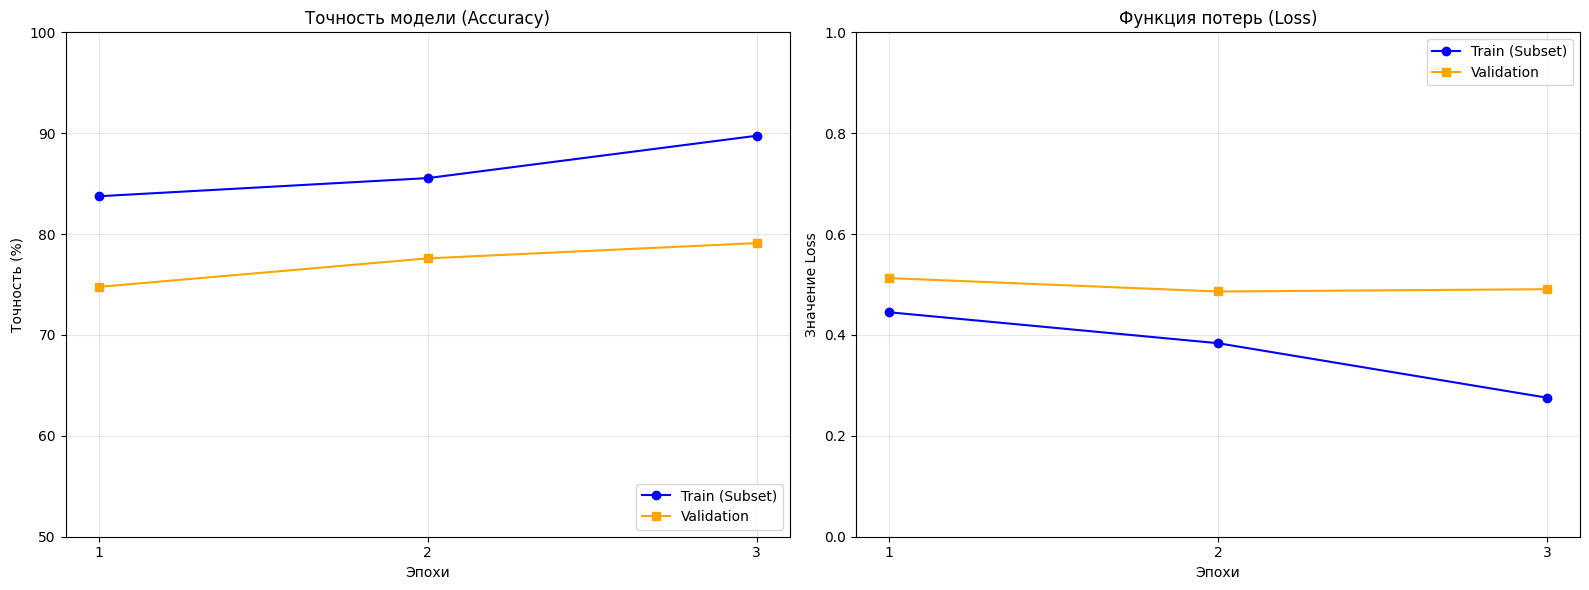

In [25]:
#Функция вывода графиков
def plot_trainer_history(trainer):                                          # Функция визуализации истории обучения из Trainer
    history = trainer.state.log_history                                     # Извлечение сырых логов из состояния объекта Trainer

    # Группируем данные по эпохам
    stats = {}
    for entry in history:                                                   # Итерация по каждой записи в истории логов
        epoch = entry.get('epoch')                                          # Получение номера эпохи из текущей записи
        if epoch is None: continue                                          # Пропуск записей, не привязанных к номеру эпохи
        epoch = int(epoch)                                                  # Округление значения до целого числа эпохи

        if epoch not in stats:                                              # Если данных по этой эпохе еще нет в словаре
            stats[epoch] = {}                                               # Инициализация пустого словаря для конкретной эпохи
        stats[epoch].update(entry)                                          # Объединение текущих данных с накопленными за эпоху

    # Фильтруем только те эпохи, где прошла полная валидация
    sorted_epochs = sorted([ep for ep in stats if 'eval_val_accuracy' in stats[ep]]) # Сортировка только завершенных эпох

    epochs = sorted_epochs                                                  # Присваивание отсортированного списка эпох для осей X
    train_acc = [stats[ep].get('eval_train_accuracy', 0) * 100 for ep in epochs] # Сбор точности обучения в процентах (Subset)
    val_acc = [stats[ep].get('eval_val_accuracy', 0) * 100 for ep in epochs]    # Сбор точности валидации в процентах
    train_loss = [stats[ep].get('eval_train_loss', 0) for ep in epochs]        # Сбор значений функции потерь при обучении
    val_loss = [stats[ep].get('eval_val_loss', 0) for ep in epochs]            # Сбор значений функции потерь при валидации

    plt.figure(figsize=(16, 6))                                             # Создание общего полотна для графиков 16x6 дюймов

    # График Accuracy
    plt.subplot(1, 2, 1)                                                    # Переход к первой области (левой) для метрики Accuracy
    plt.plot(epochs, train_acc, 'blue', marker='o', label='Train (Subset)') # Отрисовка синей линии с точками для обучения
    plt.plot(epochs, val_acc, 'orange', marker='s', label='Validation')     # Отрисовка оранжевой линии с квадратами для валидации
    plt.title('Точность модели (Accuracy)'); plt.xlabel('Эпохи'); plt.ylabel('Точность (%)') # Заголовок и подписи осей
    plt.xticks(epochs); plt.grid(True, alpha=0.3); plt.ylim(50, 100)        # Сетка, метки эпох и фиксация масштаба по вертикали
    plt.legend(loc='lower right')                                           # Отрисовка легенды в нижнем правом углу

    # График Loss
    plt.subplot(1, 2, 2)                                                    # Переход ко второй области (правой) для функции потерь
    plt.plot(epochs, train_loss, 'blue', marker='o', label='Train (Subset)') # Отрисовка синей линии потерь на обучении
    plt.plot(epochs, val_loss, 'orange', marker='s', label='Validation')    # Отрисовка оранжевой линии потерь на валидации
    plt.title('Функция потерь (Loss)'); plt.xlabel('Эпохи'); plt.ylabel('Значение Loss') # Названия осей и графика
    plt.xticks(epochs); plt.grid(True, alpha=0.3); plt.ylim(0, 1)           # Сетка, метки эпох и диапазон лосса от 0 до 1
    plt.legend(loc='upper right')                                           # Отрисовка легенды в верхнем правом углу

    plt.tight_layout(); plt.show()                                          # Оптимизация отступов и вывод финального окна

plot_trainer_history(trainer)                                              # Запуск функции для визуализации итогов обучения

Применение методики Fine-tuning для модели RuBERT-conversational с использованием технологии QLoRA позволило существенно повысить качество классификации, достигнув итогового значения accuracy 79,11% на валидационной выборке. Анализ отчета классификации демонстрирует высокую прогностическую способность модели в отношении классов «Позитивный» (F1 = 0,81) и «Негативный» (F1 = 0,84). Относительно более низкие показатели в классе «Нейтральный» (F1 = 0,71) объясняются естественной семантической амбивалентностью подобных обращений, которые зачастую содержат сухую констатацию фактов без выраженных лексических маркеров тональности. Тем не менее, общая точность системы в 79,11% подтверждает эффективность использования низкоранговых адаптеров для дообучения крупномасштабных трансформеров под задачу классификации текста

###Сохранение модели и публикация
Итоговая обученная модель (адаптер) вместе с настройками токенизатора была сохранена и загружена в публичный репозиторий Hugging Face Hub под идентификатором PTA70183292/rubert-base-cased-conversational_8bit_r64_l256. Размещение модели в облачном хранилище обеспечивает быстрый доступ к классификатору для его интеграции в веб-приложение и гарантирует воспроизводимость результатов исследования без необходимости повторного обучения. Такой подход позволяет использовать нейросеть как готовый программный модуль, который можно мгновенно развернуть на сервере для автоматической обработки и анализа тональности реальных студенческих обращений.

***Модель уже ранее была загружена в
https://huggingface.co/PTA70183292/rubert-base-cased-conversational_8bit_r64_l256 посредством выполнения 2 ячеек ниже (требуется токен)***



In [ ]:
"""login()"""

In [ ]:
"""api = HfApi()

repo_id = "PTA70183292/rubert-base-cased-conversational_8bit_r64_l256"
api.create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)

api.upload_folder(
    folder_path="./results/RuBERT_QLoRA_Final",
    repo_id=repo_id,
    repo_type="model"
    )"""

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   1%|1         |  555kB / 42.9MB            

CommitInfo(commit_url='https://huggingface.co/PTA70183292/rubert-base-cased-conversational_8bit_r64_l256/commit/9fa57cdbb1fabbf25113b552b1f17457b4636625', commit_message='Upload folder using huggingface_hub', commit_description='', oid='9fa57cdbb1fabbf25113b552b1f17457b4636625', pr_url=None, repo_url=RepoUrl('https://huggingface.co/PTA70183292/rubert-base-cased-conversational_8bit_r64_l256', endpoint='https://huggingface.co', repo_type='model', repo_id='PTA70183292/rubert-base-cased-conversational_8bit_r64_l256'), pr_revision=None, pr_num=None)

Модель успешно загружена по адресу https://huggingface.co/PTA70183292/rubert-base-cased-conversational_8bit_r64_l256  и полностью готова к импортированию в наш программный компонент в рамках дальнейшей разработки. Размещение весов в открытом репозитории Hugging Face Hub снимает необходимость локального хранения тяжелых файлов и значительно упрощает процесс развертывания системы.

Благодаря использованию стандартизированных библиотек, дообученный классификатор может быть бесшовно подключен к серверной части веб-приложения с помощью всего нескольких строк кода из . Таким образом, технический этап разработки полностью завершен: итоговый алгоритм переведен в формат готового сервиса, способного автоматически анализировать тональность реальных обращений студентов в режиме реального времени.